In [1]:
from dataclasses import dataclass, field
from typing import List
from sae_lens.training.config import LanguageModelSAERunnerConfig

@dataclass
class SAETrainConfig(LanguageModelSAERunnerConfig):
    dataset_path: str = 'imagenet_data'
    num_workers: int = 0
    num_epochs: int = 5

    expansion_factor: int = 8
    context_size: int = 257
    d_in: int = 1024
    model_name: str = "awilliamson/clipora-pubchem"
    hook_point: str = "blocks.{layer}.hook_mlp_out"
    hook_point_layer: List[int] = field(default_factory=lambda: [21])
    dead_feature_window: int = 5000
    use_ghost_grads: bool = True
    feature_sampling_window: int = 5000
    from_pretrained_path: str = None

    b_dec_init_method: str = "geometric_median"
    normalize_sae_decoder: bool = True

    lr: float = 0.0003
    l1_coefficient: int = 0.15
    lr_scheduler_name: str = "constant"
    train_batch_size_tokens: int = 1
    lr_warm_up_steps: int = 0

    n_batches_in_buffer: int = 2
    store_batch_size: int = 1

    log_to_wandb: bool = True
    wandb_project: str = "clipora-chemsae"
    wandb_entity: str = "willfulbytes"
    wandb_log_frequency: int = 25
    eval_every_n_wandb_logs: int = 10
    run_name: str = None

    device: str = "cuda"
    seed: int = 42
    n_checkpoints: int = 10
    checkpoint_path: str = "chem"
    dtype: str = "torch.float32"

In [2]:
import torch
torch.set_grad_enabled(False)

In [3]:
from torch.utils.data import Dataset
from vit_prisma.models.base_vit import HookedViT
from open_clip import tokenize
import datasets
from typing import Any, Iterator, cast
from torch.utils.data import DataLoader

class HFDataset(Dataset):
    def __init__(self, data_location, transforms, image_col, text_col):
        self.dataset = datasets.load_dataset(data_location, split="train")
        self.image_col = image_col
        self.text_col = text_col
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Remove the extra dimension by squeezing the tensor
        images = self.transforms(self.dataset[idx][self.image_col], return_tensors="pt")["pixel_values"].squeeze(0)
        texts = tokenize([self.dataset[idx][self.text_col]])[0]
        return images, texts, self.dataset[idx][self.image_col], self.dataset[idx][self.text_col], self.dataset[idx]["SMILES"]

# Update the collate functions accordingly
def collate_fn(data):
    imgs, _, _, _, _ = zip(*data)
    return torch.stack(imgs, dim=0)

def collate_fn_eval(data):
    imgs, texts, raw_imgs, raw_texts, smiles = zip(*data)
    return torch.stack(imgs, dim=0), torch.stack(texts, dim=0), raw_imgs, raw_texts, smiles


class OpenCLIPActivationsStore:
    """
    Class for streaming tokens and generating and storing activations
    while training SAEs.
    """

    def __init__(
        self,
        config: SAETrainConfig,
        model: HookedViT,
        dataset: torch.utils.data.Dataset,
        eval_dataset: torch.utils.data.Dataset = None,
        num_workers: int = 0,
    ):
        self.config = config
        assert (
            not self.config.normalize_activations
        ), "Normalize activations is currently not implemented for vision, sorry!"
        self.normalize_activations = self.config.normalize_activations
        self.model = model
        self.dataset = dataset
        self.eval_dataset = eval_dataset

        self.image_dataloader = torch.utils.data.DataLoader(
            self.dataset,
            shuffle=False,
            num_workers=num_workers,
            batch_size=self.config.store_batch_size,
            collate_fn=collate_fn,
            drop_last=True,
        )
        self.image_dataloader_eval = torch.utils.data.DataLoader(
            self.eval_dataset,
            shuffle=False,
            num_workers=num_workers,
            batch_size=self.config.store_batch_size,
            collate_fn=collate_fn_eval,
            drop_last=True,
        )

        self.image_dataloader_iter = self.get_batch_tokens_internal()
        self.image_dataloader_eval_iter = self.get_val_batch_tokens_internal()

        self.storage_buffer = self.get_buffer(self.config.n_batches_in_buffer // 2)
        self.dataloader = self.get_data_loader()


    def get_batch_tokens_internal(self):
        """
        Streams a batch of tokens from a dataset.
        """
        device = self.config.device
        while True:
            for data in self.image_dataloader:
                data.requires_grad_(False)
                yield data.to(device)  # 5

    def get_batch_tokens(self):
        return next(self.image_dataloader_iter)

    # returns the ground truth class as well.
    def get_val_batch_tokens_internal(self):
        """
        Streams a batch of tokens from a dataset.
        """
        device = self.config.device
        while True:
            for image_data, labels, _, _, smiles in self.image_dataloader_eval:
                image_data.requires_grad_(False)
                labels.requires_grad_(False)
                yield image_data.to(device), labels.to(device)

    def get_val_batch_tokens(self):
        return next(self.image_dataloader_eval_iter)

    def get_activations(self, batch_tokens: torch.Tensor, get_loss: bool = False):
        """
        Returns activations of shape (batches, context, num_layers, d_in)
        """
        layers = (
            self.config.hook_point_layer
            if isinstance(self.config.hook_point_layer, list)
            else [self.config.hook_point_layer]
        )
        act_names = [self.config.hook_point.format(layer=layer) for layer in layers]
        hook_point_max_layer = max(layers)

        if self.config.hook_point_head_index is not None:
            layerwise_activations = self.model.run_with_cache(
                batch_tokens,
                names_filter=act_names,
                stop_at_layer=hook_point_max_layer + 1,
            )[1]
            activations_list = [
                layerwise_activations[act_name][:, :, self.config.hook_point_head_index]
                for act_name in act_names
            ]
        else:
            layerwise_activations = self.model.run_with_cache(  ####
                batch_tokens,
                names_filter=act_names,
                stop_at_layer=hook_point_max_layer + 1,
            )[1]
            activations_list = [
                layerwise_activations[act_name] for act_name in act_names
            ]

        # Stack along a new dimension to keep separate layers distinct
        stacked_activations = torch.stack(activations_list, dim=2)

        return stacked_activations

    def get_buffer(self, n_batches_in_buffer: int):
        context_size = self.config.context_size
        batch_size = self.config.store_batch_size
        d_in = self.config.d_in
        total_size = batch_size * n_batches_in_buffer
        num_layers = (
            len(self.config.hook_point_layer)
            if isinstance(self.config.hook_point_layer, list)
            else 1
        )  # Number of hook points or layers

        refill_iterator = range(0, batch_size * n_batches_in_buffer, batch_size)
        # Initialize empty tensor buffer of the maximum required size with an additional dimension for layers
        new_buffer = torch.zeros(
            (total_size, context_size, num_layers, d_in),
            dtype=self.config.dtype,
            device=self.config.device,
        )

        for refill_batch_idx_start in refill_iterator:
            refill_batch_tokens = self.get_batch_tokens()  ######
            refill_activations = self.get_activations(refill_batch_tokens)

            new_buffer[
                refill_batch_idx_start : refill_batch_idx_start + batch_size, ...
            ] = refill_activations

            # pbar.update(1)

        new_buffer = new_buffer.reshape(-1, num_layers, d_in)
        new_buffer = new_buffer[torch.randperm(new_buffer.shape[0])]

        return new_buffer

    def get_data_loader(
        self,
    ) -> Iterator[Any]:
        """
        Return a torch.utils.dataloader which you can get batches from.

        Should automatically refill the buffer when it gets to n % full.
        (better mixing if you refill and shuffle regularly).

        """

        batch_size = self.config.train_batch_size_tokens

        # 1. # create new buffer by mixing stored and new buffer
        mixing_buffer = torch.cat(
            [self.get_buffer(self.config.n_batches_in_buffer // 2), self.storage_buffer], ####
            dim=0,
        )

        mixing_buffer = mixing_buffer[torch.randperm(mixing_buffer.shape[0])]

        # 2.  put 50 % in storage
        self.storage_buffer = mixing_buffer[: mixing_buffer.shape[0] // 2]

        # 3. put other 50 % in a dataloader
        dataloader = iter(
            DataLoader(
                # TODO: seems like a typing bug?
                cast(Any, mixing_buffer[mixing_buffer.shape[0] // 2 :]),
                batch_size=batch_size,
                shuffle=True,
            )
        )

        return dataloader

    def next_batch(self):
        """
        Get the next batch from the current DataLoader.
        If the DataLoader is exhausted, refill the buffer and create a new DataLoader.
        """
        try:
            # Try to get the next batch
            return next(self.dataloader)
        except StopIteration:
            # If the DataLoader is exhausted, create a new one
            self.dataloader = self.get_data_loader() #### 97
            return next(self.dataloader)


In [4]:
from sae_lens.training.sae_group import SparseAutoencoderDictionary
from transformers import CLIPProcessor

config = SAETrainConfig()
processor = CLIPProcessor.from_pretrained(config.model_name)
dataset = HFDataset("duongttr/PubChem324k_with_image", processor.image_processor, "image", "description") # load_dataset("awilliamson/fashion-train", split="train")
eval_dataset = HFDataset("duongttr/PubChem324k_with_image", processor.image_processor, "image", "description") # load_dataset("awilliamson/fashion-validation", split="train")
# cfg.training_tokens = int(1_300_000*setup_args['num_epochs']) * cfg.context_size
config.training_tokens = len(dataset) * config.num_epochs
sae_group = SparseAutoencoderDictionary.load_from_pretrained("/root/clipsee/chem/745224/awilliamson_clipora-pubchem_blocks.21.hook_mlp_out_8192_hook_point_layer_21")
model = HookedViT.from_pretrained(config.model_name, is_timm=False, is_clip=True)
model.to(config.device)

activation_store = OpenCLIPActivationsStore(
    config = config,
    model = model,
    dataset = dataset,
    eval_dataset = eval_dataset,
    num_workers = 0,
)

for i, (name, sae) in enumerate(sae_group):
    hyp = sae.cfg
    print(
        f"{i}: Name: {name} Layer {hyp.hook_point_layer}, p_norm {hyp.lp_norm}, alpha {hyp.l1_coefficient}"
    )




Run name: 8192-L1-0.15-LR-0.0003-Tokens-2.000e+06
n_tokens_per_buffer (millions): 0.016448
Lower bound: n_contexts_per_buffer (millions): 6.4e-05
Total training steps: 2000000
Total wandb updates: 80000
n_tokens_per_feature_sampling_window (millions): 1.285
n_tokens_per_dead_feature_window (millions): 1.285
We will reset the sparsity calculation 400 times.
Number tokens in sparsity calculation window: 5.00e+03
Using Ghost Grads.
Using Ghost Grads.
Using Ghost Grads.
Using Ghost Grads.
{'n_layers': 24, 'd_model': 1024, 'd_head': 64, 'model_name': '', 'n_heads': 16, 'd_mlp': 4096, 'activation_name': 'gelu', 'eps': 1e-05, 'original_architecture': 'vit_clip_vision_encoder', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 14, 'image_size': 224, 'n_classes': 768, 'n_params': None, 'layer_norm_pre': True, 'return_type': 'class_logits'}
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model awilliamson/clipora-pubchem into HookedTransformer
0: Name: awi

In [5]:
AUTOENCODER_NAME = "awilliamson_clipora-pubchem_blocks.21.hook_mlp_out_8192_hook_point_layer_21"
sparse_autoencoder = sae_group.autoencoders[AUTOENCODER_NAME]
sparse_autoencoder = sparse_autoencoder.to(config.device)
layer_num = sparse_autoencoder.cfg.hook_point_layer
print(f"Chosen layer {layer_num} hook point {sparse_autoencoder.cfg.hook_point}")

Chosen layer 21 hook point blocks.21.hook_mlp_out


In [6]:
import plotly.express as px

sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who grads
with torch.no_grad():
    batch_tokens, labels = activation_store.get_val_batch_tokens()
    _, cache = model.run_with_cache(batch_tokens)
    sae_out, feature_acts, loss, mse_loss, l1_loss, _ = sparse_autoencoder(
        cache[sparse_autoencoder.cfg.hook_point]
    )
    del cache

    # ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
    l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
    print("average l0", l0.mean().item())
    px.histogram(l0.flatten().cpu().numpy()).show()


average l0 67.41796875


In [7]:
import torch
import einops
from tqdm import tqdm
import heapq
import numpy as np
import pickle
from collections import defaultdict

@torch.no_grad()
def analyze_feature_activations(
    model,
    sparse_autoencoder,
    dataloader,
    W_enc,
    b_enc,
    k=5,
    device='cuda',
    checkpoint_file=None,
    resume_from=None
):
    if resume_from:
        with open(resume_from, 'rb') as f:
            feature_activations = pickle.load(f)
        print(f"Resumed from {resume_from}")
    else:
        model.eval()
        sparse_autoencoder.eval()
        num_features = sparse_autoencoder.cfg.d_sae
        
        # Use a min-heap to keep track of top k activations for each feature
        feature_activations = {i: [] for i in range(num_features)}
        
        for idx, (image, text, raw_image, raw_text, smiles) in enumerate(tqdm(dataloader, desc="Analyzing features")):
            # Ensure image is a batch of size 1
            if image.dim() == 3:
                image = image.unsqueeze(0)
            
            image = image.to(device)
            
            # Get the post activations from the clean run
            _, cache = model.run_with_cache(image)
            inp = cache[sparse_autoencoder.cfg.hook_point]
            b, seq_len, _ = inp.shape
            post_reshaped = einops.rearrange(inp, "batch seq d_mlp -> (batch seq) d_mlp")
            
            # Compute activations
            sae_in = post_reshaped - sparse_autoencoder.b_dec
            acts = einops.einsum(
                sae_in,
                W_enc,
                "... d_in, d_in n -> ... n",
            )
            acts = acts + b_enc
            acts = torch.nn.functional.relu(acts)
            
            unshape = einops.rearrange(acts, "(batch seq) d_in -> batch seq d_in", batch=b, seq=seq_len)
            per_image_acts = unshape.mean(1)
            
            # Update top k activations for each feature
            for feature in range(num_features):
                activation_value = per_image_acts[0, feature].item()
                if activation_value > 0:
                    item = (-activation_value, idx)  # Use negative for max-heap behavior
                    if len(feature_activations[feature]) < k:
                        heapq.heappush(feature_activations[feature], item)
                    elif item < feature_activations[feature][0]:  # Compare tuples
                        heapq.heapreplace(feature_activations[feature], item)
            
            # Clear CUDA cache to free up memory
            torch.cuda.empty_cache()
            
            # Save checkpoint
            if checkpoint_file and (idx + 1) % 1000 == 0:
                with open(f"{checkpoint_file}_{idx+1}.pkl", 'wb') as f:
                    pickle.dump(feature_activations, f)
                print(f"Checkpoint saved at image {idx+1}")
    
    # Retrieve actual data and sort the results for each feature
    print("Preparing data retrieval...")
    all_indices = set()
    for heap in feature_activations.values():
        all_indices.update(idx for _, idx in heap)
    
    print(f"Retrieving {len(all_indices)} unique items from dataset...")
    index_to_item = {}
    for idx in tqdm(all_indices, desc="Loading unique items"):
        index_to_item[idx] = dataloader.dataset[idx]
    
    print("Organizing final activations...")
    final_activations = defaultdict(list)
    for feature, heap in tqdm(feature_activations.items(), desc="Organizing results"):
        for neg_activation, idx in sorted(heap):
            image, text, raw_image, raw_text, smiles = index_to_item[idx]
            final_activations[feature].append((-neg_activation, image, text, raw_image, raw_text, smiles))
    
    return dict(final_activations)

# Usage example:
# To start from scratch and save checkpoints:
# results = analyze_feature_activations(..., checkpoint_file='checkpoint')

# To resume from a checkpoint:
# results = analyze_feature_activations(..., resume_from='checkpoint_1000.pkl')

In [8]:
top_activations = analyze_feature_activations(model, sparse_autoencoder, activation_store.image_dataloader_eval, sparse_autoencoder.W_enc, sparse_autoencoder.b_enc, k=500, device=config.device)

Analyzing features:  37%|███▋      | 110108/298083 [4:26:04<10:54:21,  4.79it/s]

In [9]:
# do some summary stats on the number of activations per feature and the average activation value
num_activations = []
avg_activation = []
for feature, activations in top_activations.items():
    num_activations.append(len(activations))
    avg_activation.append(np.mean([act[0] for act in activations]))

px.histogram(num_activations).show()
px.histogram(avg_activation).show()



Feature 6032
Activation 1: 0.001387394848279655


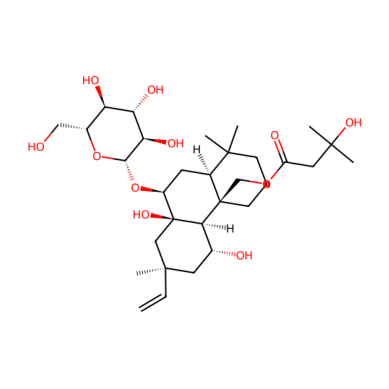

Activation 2: 0.0011142329312860966


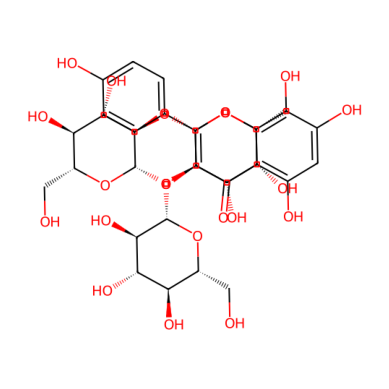

Activation 3: 0.001106112147681415


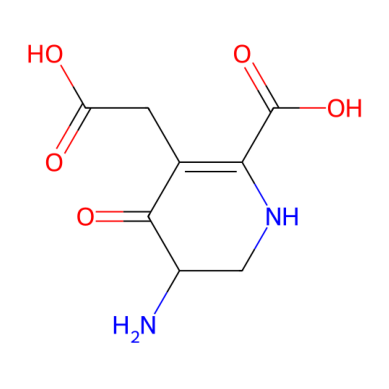

Activation 4: 0.0010838598245754838


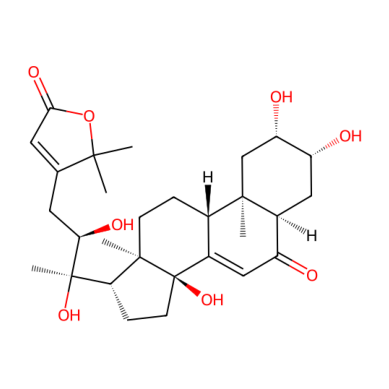

Activation 5: 0.0010452260030433536


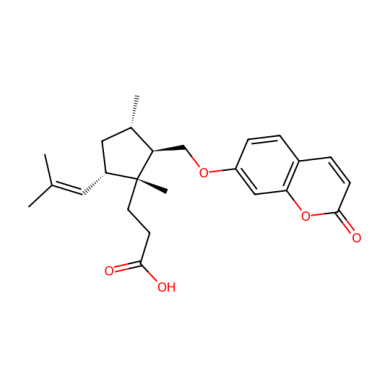

Feature 5816
Activation 1: 0.023967668414115906


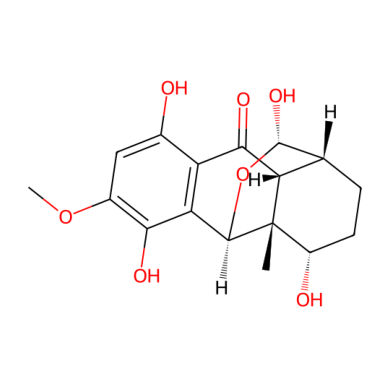

Activation 2: 0.0072817811742424965


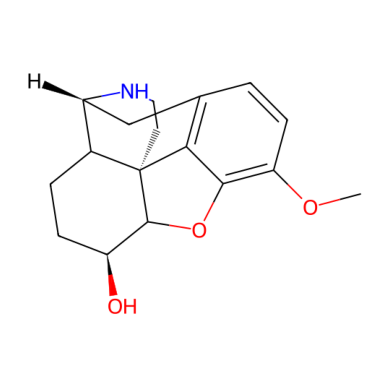

Activation 3: 0.00462944945320487


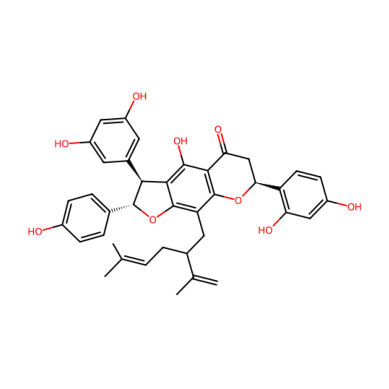

Activation 4: 0.004268735181540251


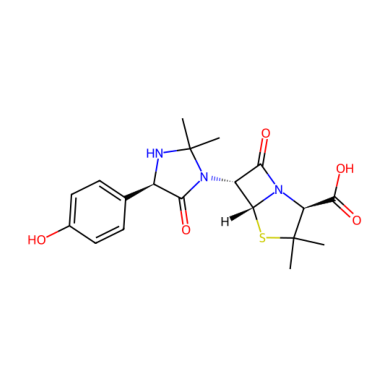

Activation 5: 0.004159827250987291


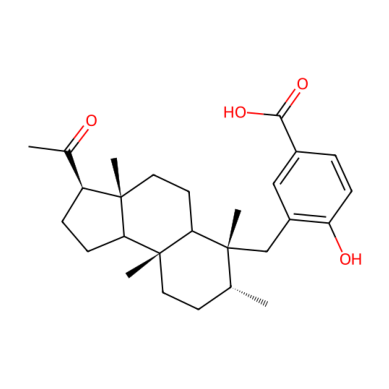

Feature 6554
Activation 1: 0.001731004100292921


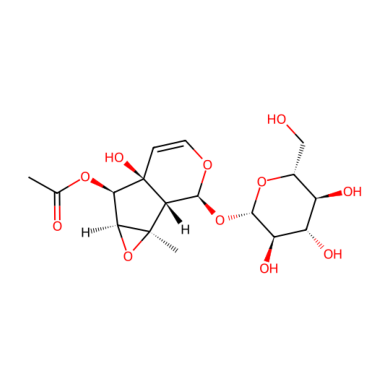

Activation 2: 0.0014905324205756187


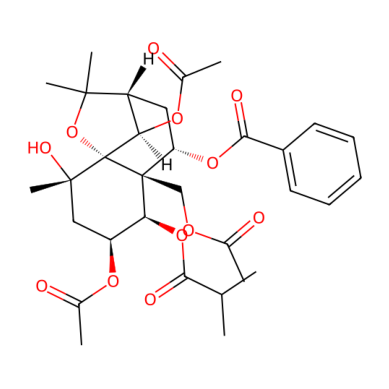

Activation 3: 0.0006950735114514828


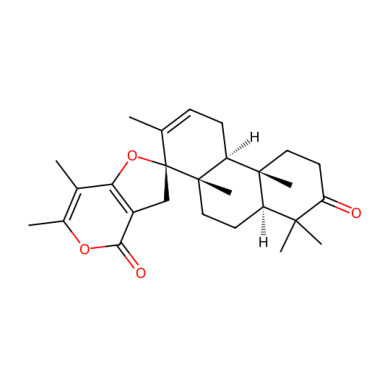

Activation 4: 0.0006176832830533385


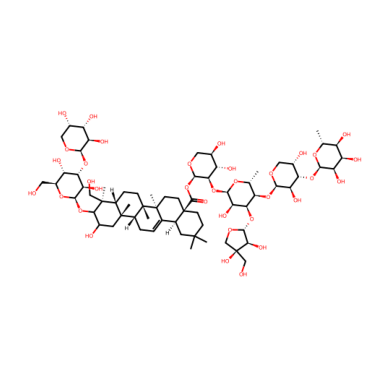

Activation 5: 0.0005000349483452737


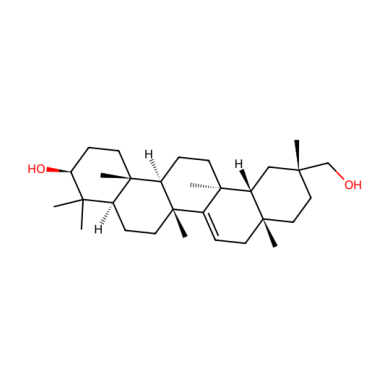

Feature 2023
Activation 1: 0.0026265266351401806


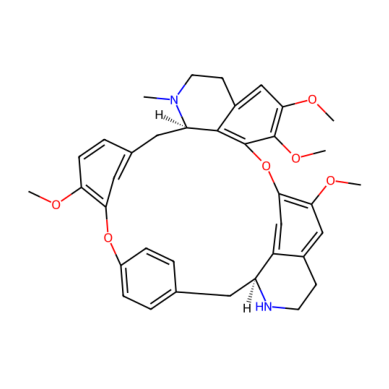

Activation 2: 0.0014193926472216845


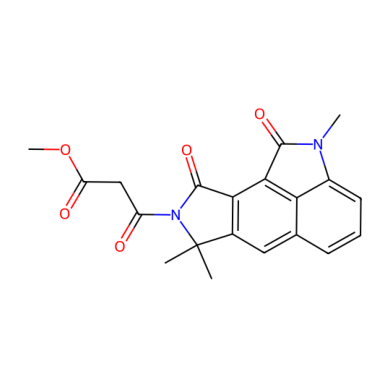

Activation 3: 0.0014111174969002604


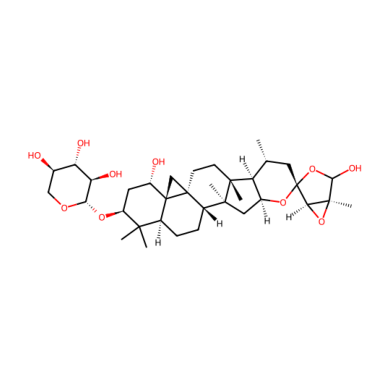

Activation 4: 0.0007186820148490369


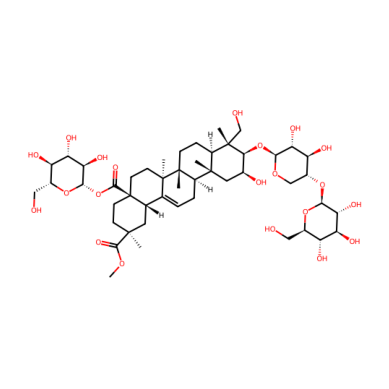

Activation 5: 0.0006980412872508168


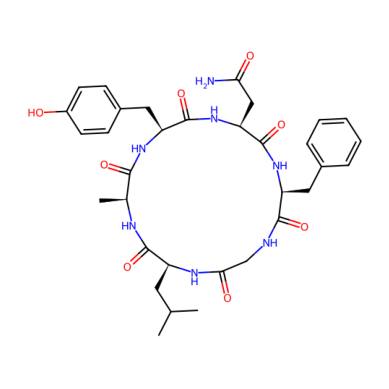

Feature 7728
Activation 1: 0.18349666893482208


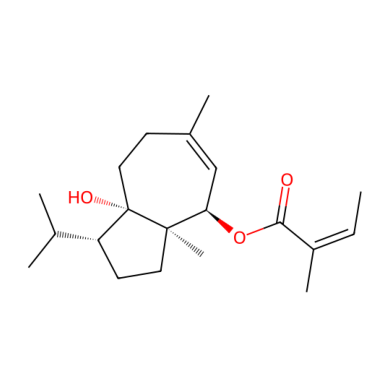

Activation 2: 0.059898458421230316


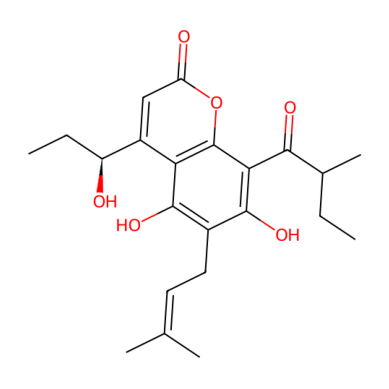

Activation 3: 0.05946356803178787


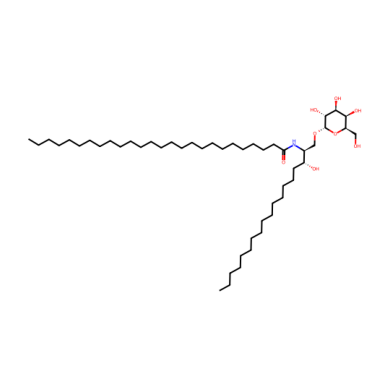

Activation 4: 0.05836020037531853


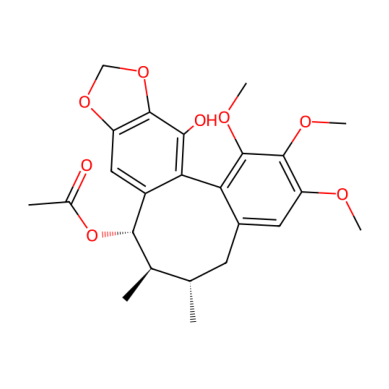

Activation 5: 0.057950008660554886


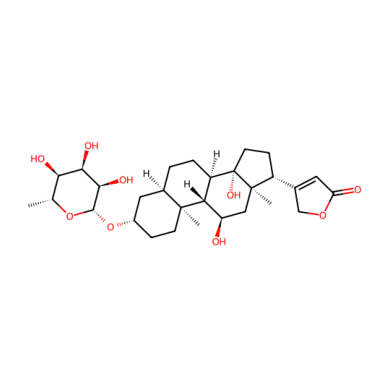

In [10]:
# do some analysis on the top activations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_top_activations(top_activations, num_features=5, num_images=5):
    for feature in random.sample(range(len(top_activations)), num_features):
        print(f"Feature {feature}")
        for i, (activation_value, image, text, raw_image, raw_text, smiles) in enumerate(top_activations.get(feature, [])[:num_images]):
            print(f"Activation {i+1}: {activation_value}")
            plt.imshow(raw_image)
            plt.axis("off")
            plt.show()

show_top_activations(top_activations, num_features=5, num_images=5)

In [1]:
import pickle
import torch
import numpy as np
import os

def save_analysis_results(results, filename_base):
    """
    Save the analysis results to files, handling large tensor data efficiently.
    
    Args:
    results (dict): The dictionary returned by analyze_feature_activations
    filename_base (str): The base name for the files to save the results to
    """
    processed_results = {}
    tensor_data = {}
    
    for feature, activations in results.items():
        processed_activations = []
        for i, (activation_value, image, text, raw_image, raw_text, smiles) in enumerate(activations):
            # Store everything else in the main structure
            processed_activations.append((
                activation_value,
                text,
                raw_image,  # Assuming this is not a large tensor
                raw_text,
                smiles
            ))
        processed_results[feature] = processed_activations
    
    # Save the main structure
    with open(f"{filename_base}_structure.pkl", 'wb') as f:
        pickle.dump(processed_results, f)

    print(f"Results saved to {filename_base}_structure.pkl")

def load_analysis_results(filename_base):
    """
    Load the analysis results from files.
    
    Args:
    filename_base (str): The base name of the files to load the results from
    
    Returns:
    dict: The loaded results
    """
    # Load the main structure
    with open(f"{filename_base}_structure.pkl", 'rb') as f:
        results = pickle.load(f)
    
    # Reconstruct the original structure
    reconstructed_results = {}
    for feature, activations in results.items():
        reconstructed_activations = []
        for activation_value, text, raw_image, raw_text, smiles in activations:
            reconstructed_activations.append((
                activation_value,
                text,
                raw_image,
                raw_text,
                smiles
            ))
        reconstructed_results[feature] = reconstructed_activations
    
    print(f"Results loaded from {filename_base}_structure.pkl and {filename_base}_tensor_data.npy")
    return reconstructed_results

# Usage example:
# Saving:
# save_analysis_results(feature_activations, 'analysis_results')

# Loading:
# loaded_results = load_analysis_results('analysis_results')

In [12]:
save_analysis_results(top_activations, 'top_activations.pkl')

Results saved to top_activations.pkl_structure.pkl


In [2]:
results = load_analysis_results('top_activations.pkl')

/root/clipsee/.venv/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Results loaded from top_activations.pkl_structure.pkl and top_activations.pkl_tensor_data.npy


In [3]:
# let's sort the items in each feature by activation value
results_sorted = {feature: sorted(activations, key=lambda x: x[0], reverse=True) for feature, activations in results.items()}

In [4]:
# let's get the max, min, and mean activation value for each feature
feature_stats = {}
for feature, activations in results.items():
    activation_values = [act[0] for act in activations]
    feature_stats[feature] = {
        "max": max(activation_values),
        "min": min(activation_values),
        "mean": np.mean(activation_values)
    }

# now sort the feature stats by max activation value
sorted_feature_stats = dict(sorted(feature_stats.items(), key=lambda x: x[1]["max"], reverse=True))

# let's print the top 10 features by max activation value
for feature, stats in list(sorted_feature_stats.items())[:10]:
    print(f"Feature {feature}: Max activation {stats['max']}, Min activation {stats['min']}, Mean activation {stats['mean']}")

Feature 3395: Max activation 1.366689920425415, Min activation 0.0004454409936442971, Mean activation 0.03918428419798147
Feature 7484: Max activation 1.358596920967102, Min activation 3.914076842193026e-06, Mean activation 0.012416039543979423
Feature 4673: Max activation 1.1815325021743774, Min activation 6.117564771557227e-05, Mean activation 0.17827883900336747
Feature 421: Max activation 1.0874295234680176, Min activation 0.0037049653474241495, Mean activation 0.12801893345965074
Feature 4699: Max activation 1.0827380418777466, Min activation 0.0001427334063919261, Mean activation 0.04294825935360859
Feature 6702: Max activation 1.0060884952545166, Min activation 0.00011916235234821215, Mean activation 0.14263237023168768
Feature 2721: Max activation 0.9929305911064148, Min activation 4.442404315341264e-05, Mean activation 0.09773088500156882
Feature 6739: Max activation 0.9004644751548767, Min activation 8.012418106773112e-07, Mean activation 0.007100453771108618
Feature 5513: Ma

In [17]:
import matplotlib.pyplot as plt

def get_feature_examples(feature_idx, num_examples=5, show_images=True):
    print(f"Feature {feature_idx}")
    for i, (activation_value, text, raw_image, raw_text, smiles) in enumerate(results_sorted.get(feature_idx, [])[:num_examples]):
        # let's cleanly print the activation, description, and SMILES
        print(f"Activation {i+1}: {activation_value}")
        print(f"Description: {raw_text}")
        print(f"SMILES: {smiles}")
        if show_images:
            plt.imshow(raw_image)
            plt.axis("off")
            plt.show()


Feature 6702
Activation 1: 1.0060884952545166
Description: The molecule is a natural product found in Senna multiglandulosa and Senna sophera with data available.
SMILES: CC1=CC2=C(C(=C1)O)C(=O)C3=C(C(=C(C=C3C2=O)OC)C4=C5C(=C(C6=C4C=C(C=C6O)OC)O)C(=O)C=C(C5=O)C)O


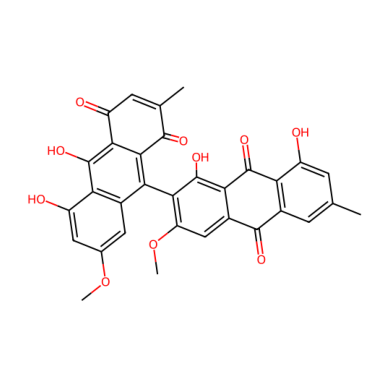

Activation 2: 0.4908648729324341
Description: The molecule is a natural product found in Magnolia denudata with data available.
SMILES: CC1C(OC2=CC(=O)C(=CC12CC=C)OC)C3=CC4=C(C=C3)OCO4


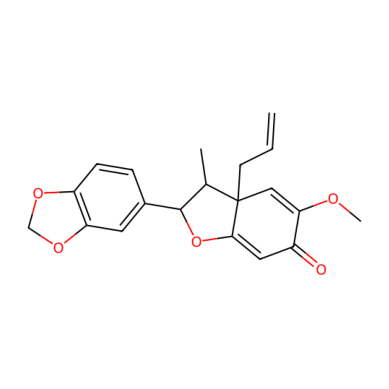

Activation 3: 0.4720788896083832
Description: The molecule is a fluoroindole that is 6-fluoroindole in which the hydrogen at position 3 has been replaced by a 2-(pyridin-3-yl)vinyl group (trans configuration). It is a selective inhibitor of tryptophan 2,3-dioxygenase (TDO), which directs the conversion of trypophan to kynurenin. It has a role as an EC 1.13.11.11 (tryptophan 2,3-dioxygenase) inhibitor. It is a fluoroindole, a member of pyridines and an olefinic compound.
SMILES: C1=CC(=CN=C1)/C=C/C2=CNC3=C2C=CC(=C3)F


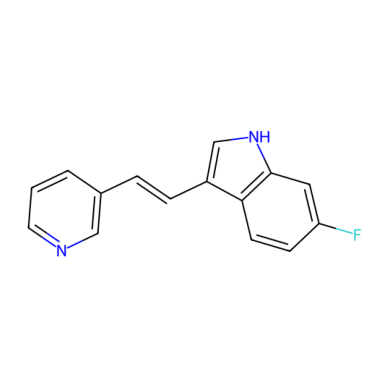

Activation 4: 0.4612273573875427
Description: The molecule is a natural product found in Sarcodon scabrosus, Boletopsis, and other organisms with data available.
SMILES: CC(=O)OC1=C(C2=C(C(=C1C3=CC=C(C=C3)O)O)OC4=CC(=C(C=C42)O)O)OC(=O)C


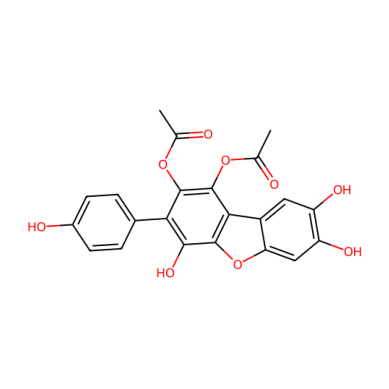

Activation 5: 0.46059882640838623
Description: The molecule is a natural product found in Machilus zuihoensis with data available.
SMILES: CCCCCCCCCCCCCCCCC/C=C\1/[C@H]([C@](OC1=O)(C)OC)O


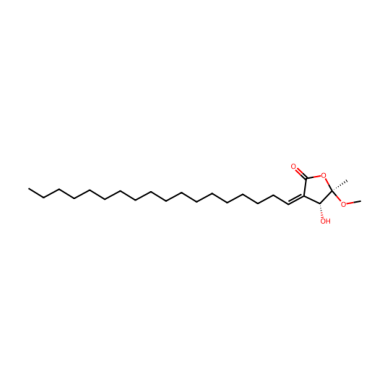

In [25]:
get_feature_examples(6702, num_examples=5, show_images=True)